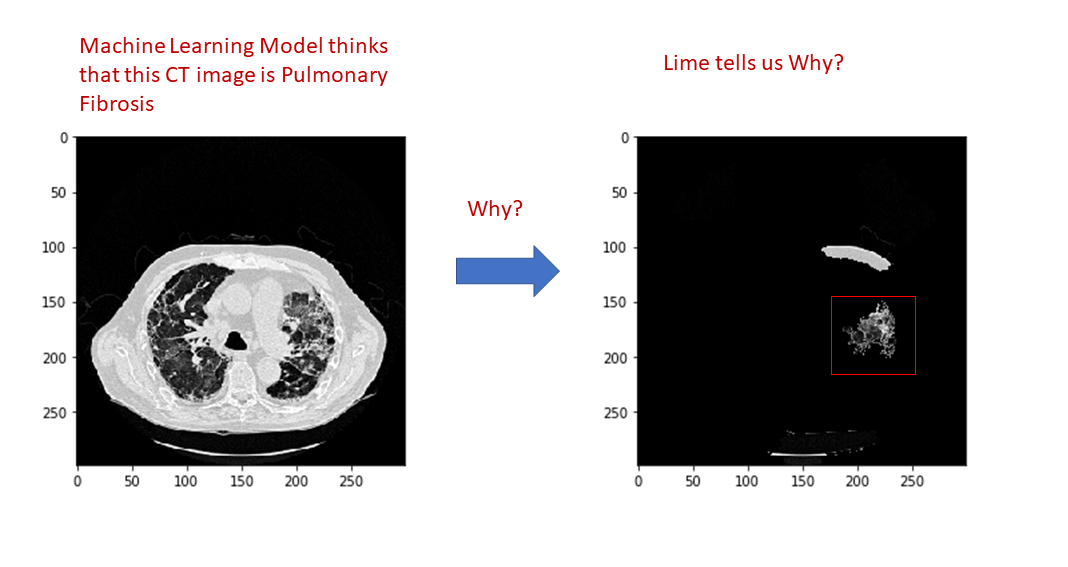

In [ ]:
from tensorflow.keras.applications.xception import Xception, decode_predictions, preprocess_input
from tensorflow import keras
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TASK: LOAD SAVED MODEL 

In [ ]:
model_filepath= "/content/drive/MyDrive/ILD_3 classes_May_2021/trained_model_split_folders"
model = keras.models.load_model(model_filepath)

In [ ]:
model.summary()

In [ ]:
#Get labels of images

ild_labels = pd.read_csv('/content/drive/MyDrive/ILD_3 classes_May_2021/ILD_labels.csv')

In [ ]:
ild_labels

,Class,class_code
0,Healthy,0
1,Nonspecific interstitial pneumonia,1
2,Pulmonary fibrosis,2


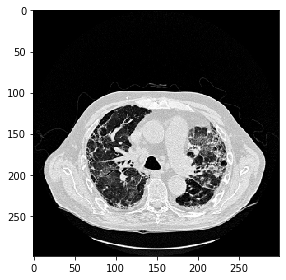

In [ ]:
#Read and process test image
img = ('/content/drive/MyDrive/ILD_3 classes_May_2021/Split_Tiff_unsegmented_folders/test/pulmonary_fibrosis/img113.tif')

Xi = skimage.io.imread(img)
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #model pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before model preprocessing

GET PREDICTIONS AND LABEL ON TEST IMAGE USING SAVED MODEL

In [ ]:
test_img = ('/content/drive/MyDrive/ILD_3 classes_May_2021/Split_Tiff_unsegmented_folders/test/pulmonary_fibrosis/img113.tif')
np.random.seed(222)
preds = model.predict(Xi[np.newaxis])


In [ ]:
top_pred_classes = preds[0].argsort()[-3:][::-1]
top_pred_classes

array([2, 1, 0])

In [ ]:
#2 is pulmonary fibrosis label (see above), so correct prediction

In [ ]:
#LIME explanations

In [ ]:
#Extract super-pixels from image

superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

55

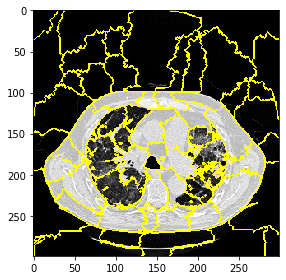

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
#Create random perturbations

num_perturb = 10000
perturbations = np.random.binomial(1, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

#Here, 1 represent that a superpixel is on and 0 represents it is off

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0])

In [ ]:
perturbations.shape

(10000, 55)

In [ ]:
#The following function perturb_image perturbs the given image (img) based on a perturbation vector (perturbation) and predefined superpixels (segments).

def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  return perturbed_image

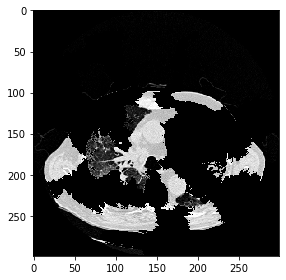

In [ ]:
#Let's use the previous function to see what a perturbed image would look like
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
#Use ML classifier to predict classes of new generated images

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(10000, 1, 3)

In [ ]:
#Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image

original_image = np.ones(num_superpixels)[np.newaxis] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine')
distances.shape

(10000,)

In [ ]:
#Use kernel function to compute weights
kernel_width = 0.25
weights = np(np.exp(-(distances)/kernel_width)) #Kernel function
weights.shape

(10000,)

In [ ]:
#Use perturbations, predictions and weights to fit an explainable (linear) model
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.02241461, -0.07429315, -0.00717286, -0.02881151, -0.03767   ,
       -0.03574812,  0.07007785,  0.06684239, -0.00986359, -0.01937679,
       -0.01226043, -0.01267986, -0.00247874, -0.01445606, -0.01478007,
        0.011688  , -0.02195142, -0.01284916, -0.01715062,  0.02106529,
        0.00441025,  0.00608863,  0.01170762, -0.0049598 ,  0.00534611,
        0.0016521 , -0.00080623,  0.00252142, -0.02061556,  0.00372305,
        0.01692567,  0.01551325,  0.00308909,  0.0335969 , -0.01376017,
       -0.00166522, -0.03176419,  0.0107844 , -0.00456261, -0.02466354,
       -0.01386982,  0.00194429, -0.00499618,  0.02641096, -0.02365553,
        0.01082064,  0.01269731, -0.00234234,  0.00034367,  0.0235523 ,
        0.0066503 ,  0.02612395,  0.00440624,  0.0607379 ,  0.03352542])

In [ ]:
#Compute top features (superpixels)
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features] 
top_features

array([33, 53,  7,  6])

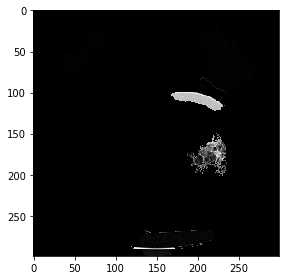

In [ ]:
#Show LIME explanation (image with top features)
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

The model is using the honeycombing pattern on the CT (shown above) to classify why the image is pulmonary fibrosis.